In [18]:
import numpy as np
from sklearn.datasets import make_classification
from torch import nn, optim
from skorch import NeuralNetClassifier
from pyperch.neural.backprop_nn import BackpropModule
# from pyperch.utils.decorators import add_to
from pyperch.neural.rhc_nn import RHCModule
from pyperch.utils.decorators import add_to
from pyperch.neural.sa_nn import SAModule
# from PYPERCH.pyperch.neural.ga_nn import GAModule
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from yellowbrick.model_selection import LearningCurve,ValidationCurve
import mlrose_hiive as mlrose
from sklearn.model_selection import train_test_split, learning_curve,validation_curve
from sklearn.pipeline import make_pipeline
import time


In [19]:
diabetes = pd.read_csv('/workspaces/7641HW2/diabetes.csv')
diabetes['Outcome'] = diabetes['Outcome'].astype('category')
scaler = StandardScaler()
num_var =  ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']
diabetes[num_var] = scaler.fit_transform(diabetes[num_var])
cols = list(diabetes.columns)
cols.insert(0, cols.pop(cols.index('Outcome')))
diabetes = diabetes[cols]

In [20]:
def loading_data():
    X2 = np.array(diabetes.values[:,1:-1].astype(np.float32))
    y2 = np.array(diabetes.values[:,0].ravel().astype(np.int64))
    return X2,y2

In [21]:
cX,cY = loading_data()

In [22]:
def get_activation_fn(name):
    if name == 'relu':
        return nn.ReLU()
    elif name == 'sigmoid':
        return nn.Sigmoid()
    elif name == 'tanh':
        return nn.Tanh()
    elif name == 'leaky_relu':
        return nn.LeakyReLU()
    else:
        raise ValueError(f"Unknown activation function: {name}")

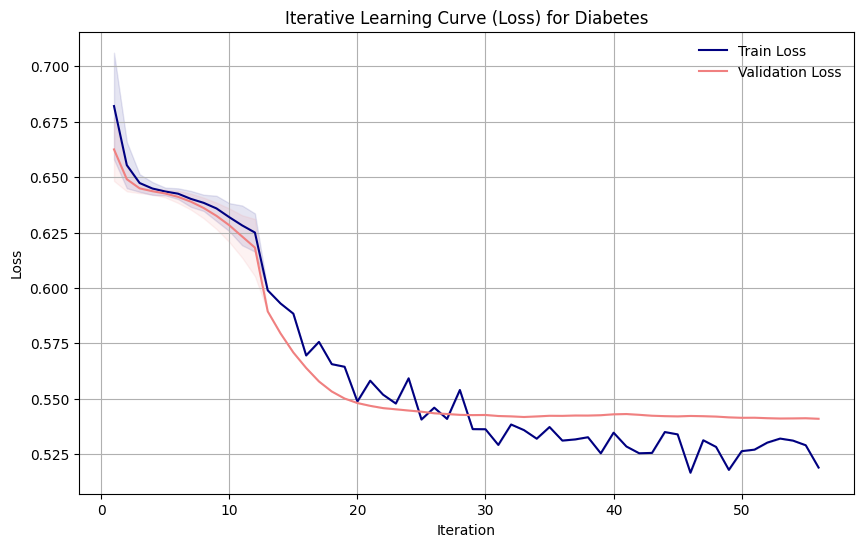

In [42]:
from skorch.callbacks import Callback
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, make_scorer
from skorch.callbacks import EpochScoring,EarlyStopping
from sklearn.model_selection import cross_val_score, StratifiedKFold

activation_fn_name = 'sigmoid'
activation_fn = get_activation_fn(activation_fn_name)

# Define the neural net
net = NeuralNetClassifier(
    module=BackpropModule,
    module__input_dim=cX.shape[1],
    module__output_dim=2,
    module__hidden_units=10,
    module__hidden_layers=1,
    module__activation=activation_fn,
    module__dropout_percent=0.5,
    max_epochs=500,
    lr=0.01,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    callbacks=[
        EpochScoring(scoring='accuracy', name='train_acc', on_train=True),
        EarlyStopping(monitor='train_acc', patience=10, lower_is_better=False),
    ],
    verbose=0,
)

# Use StratifiedKFold for cross-validation to ensure class balance
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_losses = []
valid_losses = []

for train_index, valid_index in kf.split(cX, cY):
    X_train, X_valid = cX[train_index], cX[valid_index]
    y_train, y_valid = cY[train_index], cY[valid_index]
    
    net.fit(X_train, y_train)
    
    train_loss = np.array([epoch['train_loss'] for epoch in net.history])
    valid_loss = np.array([epoch['valid_loss'] for epoch in net.history])
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

max_len = max(len(tl) for tl in train_losses)
train_losses_padded = np.array([np.pad(tl, (0, max_len - len(tl)), 'constant', constant_values=np.nan) for tl in train_losses])
valid_losses_padded = np.array([np.pad(vl, (0, max_len - len(vl)), 'constant', constant_values=np.nan) for vl in valid_losses])

# Calculate mean and std for train and validation losses across folds
train_losses_mean = np.nanmean(train_losses_padded, axis=0)
train_losses_std = np.nanstd(train_losses_padded, axis=0)
valid_losses_mean = np.nanmean(valid_losses_padded, axis=0)
valid_losses_std = np.nanstd(valid_losses_padded, axis=0)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
iterations = range(1, len(train_losses_mean) + 1)
plt.fill_between(iterations, train_losses_mean - train_losses_std, train_losses_mean + train_losses_std, alpha=0.1, color='navy')
plt.fill_between(iterations, valid_losses_mean - valid_losses_std, valid_losses_mean + valid_losses_std, alpha=0.1, color='lightcoral')
plt.plot(iterations, train_losses_mean, label='Train Loss', color='navy')
plt.plot(iterations, valid_losses_mean, label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss) for Diabetes")
plt.grid(visible=True)
plt.legend(frameon=False)
plt.savefig('LossCurveforNNDiabetes', dpi=300)
plt.show()

/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-p

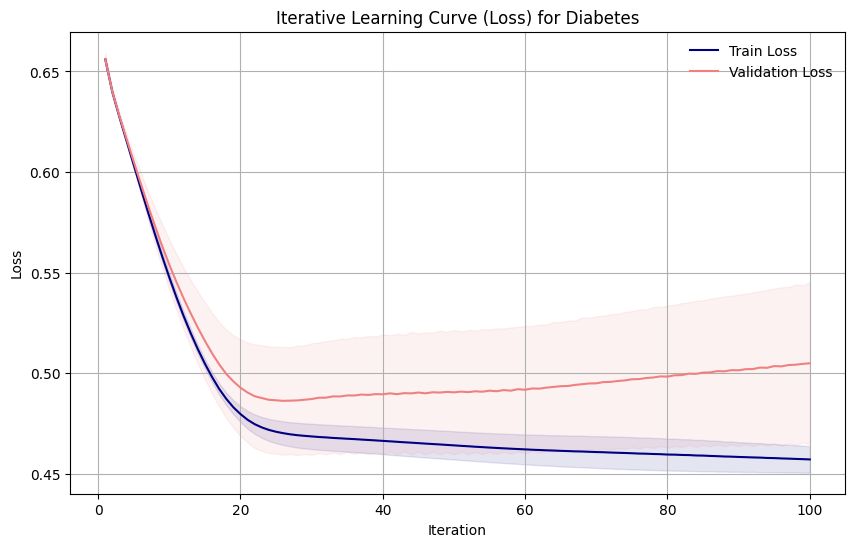

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss

# Define the neural net parameters
activation_fn = 'logistic'  # equivalent to sigmoid
hidden_layer_sizes = (10,)
max_iter = 100

# Use StratifiedKFold for cross-validation to ensure class balance
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_losses = []
valid_losses = []

for train_index, valid_index in kf.split(cX, cY):
    X_train, X_valid = cX[train_index], cX[valid_index]
    y_train, y_valid = cY[train_index], cY[valid_index]

    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                        activation=activation_fn,
                        solver='adam',
                        alpha=0.0001,
                        batch_size='auto',
                        learning_rate='constant',
                        learning_rate_init=0.01,
                        max_iter=1,
                        shuffle=True,
                        random_state=42,
                        warm_start=True,
                        early_stopping=True,
                        n_iter_no_change=10)

    train_loss = []
    valid_loss = []

    for epoch in range(max_iter):
        clf.fit(X_train, y_train)
        
        train_pred_proba = clf.predict_proba(X_train)
        valid_pred_proba = clf.predict_proba(X_valid)
        
        train_loss.append(log_loss(y_train, train_pred_proba))
        valid_loss.append(log_loss(y_valid, valid_pred_proba))

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

max_len = max(len(tl) for tl in train_losses)
train_losses_padded = np.array([np.pad(tl, (0, max_len - len(tl)), 'constant', constant_values=np.nan) for tl in train_losses])
valid_losses_padded = np.array([np.pad(vl, (0, max_len - len(vl)), 'constant', constant_values=np.nan) for vl in valid_losses])

# Calculate mean and std for train and validation losses across folds
train_losses_mean = np.nanmean(train_losses_padded, axis=0)
train_losses_std = np.nanstd(train_losses_padded, axis=0)
valid_losses_mean = np.nanmean(valid_losses_padded, axis=0)
valid_losses_std = np.nanstd(valid_losses_padded, axis=0)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
iterations = range(1, len(train_losses_mean) + 1)
plt.fill_between(iterations, train_losses_mean - train_losses_std, train_losses_mean + train_losses_std, alpha=0.1, color='navy')
plt.fill_between(iterations, valid_losses_mean - valid_losses_std, valid_losses_mean + valid_losses_std, alpha=0.1, color='lightcoral')
plt.plot(iterations, train_losses_mean, label='Train Loss', color='navy')
plt.plot(iterations, valid_losses_mean, label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss) for Diabetes")
plt.grid(visible=True)
plt.legend(frameon=False)
plt.savefig('LossCurveforNNDiabetes', dpi=300)
plt.show()

In [9]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['relu', 'logistic', 'tanh'],
    'learning_rate_init': [0.01, 0.02, 0.1],
    'max_iter': [50, 100, 200]
}

# Initialize the MLPClassifier
clf = MLPClassifier(solver='adam', random_state=42,early_stopping=True)

# Initialize the GridSearchCV
gs = GridSearchCV(estimator=clf, param_grid=param_grid, refit=True, cv=3, scoring='accuracy', verbose=2)

# Fit the GridSearchCV
gs.fit(cX, cY)

# Print the best score and parameters
print("Best score: {:.3f}".format(gs.best_score_))
print("Best parameters:", gs.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=50; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=50; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=50; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=100; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=100; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=100; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=200; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=200; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning

In [1]:
#GD

#Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.02, 'max_iter': 50}

RHC

In [7]:
import mlrose_hiive as mlrose
from mlrose_hiive import SARunner, GARunner, NNGSRunner
from IPython.core.display import display, HTML


In [8]:
X_train, X_test, y_train, y_test = train_test_split(cX, cY, test_size=0.2, random_state=42)

In [9]:
grid_search_parameters = {
    'max_iters': [500],                          # nn params
    'learning_rate': [2e-2],                       # nn params
    'activation': [mlrose.relu,mlrose.tanh,mlrose.sigmoid],            # nn params
    'restarts': [1,5,10],                             # rhc params`b`
}

In [10]:
nnr = mlrose.NNGSRunner(
    x_train=X_train,
    y_train=y_train,
    x_test=X_test,
    y_test=y_test,
    experiment_name='nn_test_rhc',
    algorithm=mlrose.algorithms.rhc.random_hill_climb,
    grid_search_parameters=grid_search_parameters,
    iteration_list=[50,100,500],
    hidden_layer_sizes=[[50]],
    bias=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=500,
    n_jobs=-1,
    seed=42,
    output_directory=None
)

# Run the experiment
run_stats_df, curves_df, cv_results_df, grid_search_cv = nnr.run()


HTML(cv_results_df[['mean_test_score', 'rank_test_score', 'mean_train_score', 'param_activation', 'param_hidden_layer_sizes', 'param_learning_rate',
                    'param_max_iters', 'param_restarts']].to_html())


Fitting 5 folds for each of 9 candidates, totalling 45 fits


,mean_test_score,rank_test_score,mean_train_score,param_activation,param_hidden_layer_sizes,param_learning_rate,param_max_iters,param_restarts
0,0.718547,2,0.728455,relu,[50],0.02,500,1
1,0.711094,3,0.722318,relu,[50],0.02,500,5
2,0.726258,1,0.737405,relu,[50],0.02,500,10
3,0.686676,8,0.706698,tanh,[50],0.02,500,1
4,0.679193,9,0.695141,tanh,[50],0.02,500,5
5,0.696393,5,0.705945,tanh,[50],0.02,500,10
6,0.697141,4,0.713737,sigmoid,[50],0.02,500,1
7,0.688966,7,0.700601,sigmoid,[50],0.02,500,5
8,0.695239,6,0.711023,sigmoid,[50],0.02,500,10


RHC Best Parameters

In [11]:
grid_search_cv.best_params_

{'activation': <function mlrose_hiive.neural.activation.relu.relu(x, deriv=False)>,
 'hidden_layer_sizes': [50],
 'learning_rate': 0.02,
 'max_iters': 500,
 'restarts': 10}

In [12]:
print(f"Best score: {grid_search_cv.best_score_}")

Best score: 0.7262584978689566


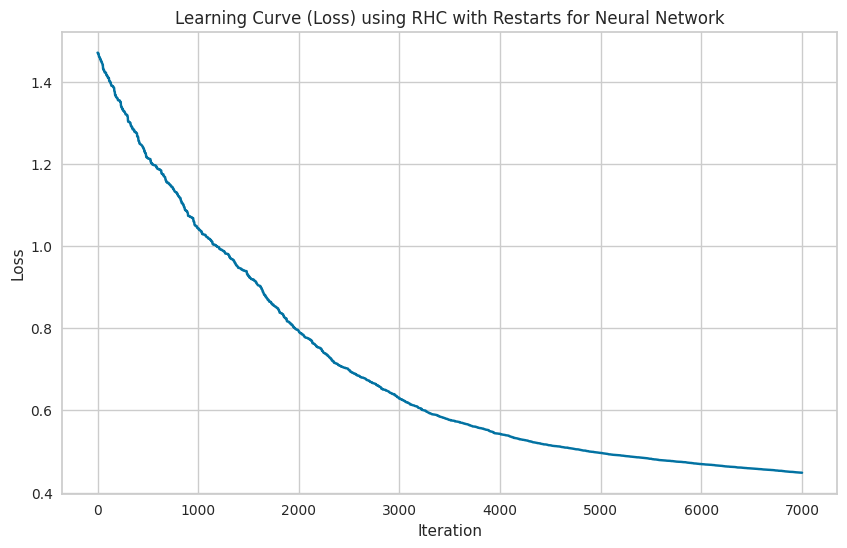

In [26]:
X_train, X_test, y_train, y_test = train_test_split(cX, cY, test_size=0.2, random_state=42)

nn_model = mlrose.NeuralNetwork(
    hidden_nodes=[50], 
    activation='relu', 
    algorithm='random_hill_climb', 
    max_iters=7000, 
    bias=True, 
    is_classifier=True, 
    learning_rate=0.02, 
    early_stopping=True, 
    clip_max=1e+10, 
    max_attempts=100, 
    random_state=42, 
    curve=True,
    restarts=10
)

# Fit the neural network
nn_model.fit(X_train, y_train)

training_fitness_curve = nn_model.fitness_curve

# Transform fitness to loss if necessary
# Assuming fitness is actually negative log loss, otherwise adjust as needed
loss_curve = -training_fitness_curve

# Plotting the loss curve
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(nn_model.fitness_curve)),nn_model.fitness_curve[:,0])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Learning Curve (Loss) using RHC with Restarts for Neural Network")
plt.grid(visible=True)
plt.legend(frameon=False)
plt.savefig('LossCurveforNN_RHC_RestartsFinal', dpi=300)
plt.show()

SA

In [14]:
grid_search_parameters = ({
        'max_iters': [1000],                     # nn params
        'learning_rate': [0.001, 0.002, 0.003],                         # nn params
        'schedule': [mlrose.GeomDecay(1),mlrose.GeomDecay(100), mlrose.GeomDecay(1000)],  # sa params
    })

In [15]:
nn_model = mlrose.NeuralNetwork(
    hidden_nodes=[50],
    activation='relu',
    algorithm='simulated_annealing',
    max_iters=1000,
    bias=True,
    is_classifier=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=100,
    random_state=42
)

# Define the hyperparameter grid for Simulated Annealing
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'schedule': [mlrose.ExpDecay(), mlrose.GeomDecay(), mlrose.ArithDecay()]
}

grid_search = GridSearchCV(estimator=nn_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best score and parameters
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .................learning_rate=0.0001, schedule=1.0; total time=   4.6s
[CV] END .................learning_rate=0.0001, schedule=1.0; total time=   4.7s
[CV] END .................learning_rate=0.0001, schedule=1.0; total time=   4.7s
[CV] END .................learning_rate=0.0001, schedule=1.0; total time=   4.8s
[CV] END .................learning_rate=0.0001, schedule=1.0; total time=   4.6s
[CV] END .................learning_rate=0.0001, schedule=1.0; total time=   4.6s
[CV] END .................learning_rate=0.0001, schedule=1.0; total time=   5.0s
[CV] END .................learning_rate=0.0001, schedule=1.0; total time=   4.9s
[CV] END .................learning_rate=0.0001, schedule=1.0; total time=   4.6s
[CV] END ..................learning_rate=0.001, schedule=1.0; total time=   4.7s
[CV] END ..................learning_rate=0.001, schedule=1.0; total time=   4.7s
[CV] END ..................learning_rate=0.001, 

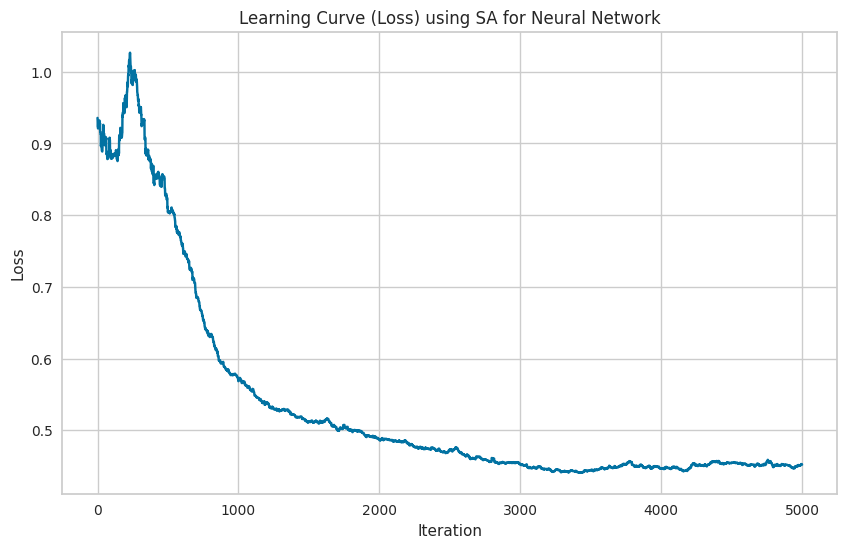

In [24]:

nn_model = mlrose.NeuralNetwork(
    hidden_nodes=[50], 
    activation='relu', 
    algorithm='simulated_annealing', 
    max_iters=5000, 
    bias=True, 
    is_classifier=True, 
    learning_rate=0.1, 
    early_stopping=True, 
    clip_max=1e+10, 
    max_attempts=100, 
    random_state=42, 
    curve=True,
    restarts=10,
    schedule=mlrose.GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001)
)

# Fit the neural network
nn_model.fit(X_train, y_train)

fitness_curve = nn_model.fitness_curve

# Transform fitness to loss if necessary
# Assuming fitness is actually negative log loss, otherwise adjust as needed
loss_curve = -fitness_curve

# Plotting the loss curve
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(nn_model.fitness_curve)),nn_model.fitness_curve[:,0])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Learning Curve (Loss) using SA for Neural Network")
plt.grid(visible=True)
plt.legend(frameon=False)
plt.savefig('LossCurveforNN_SAFinal', dpi=300)
plt.show()

In [17]:
nn_model = mlrose.NeuralNetwork(
    hidden_nodes=[50],
    activation='relu',
    algorithm='genetic_alg',
    max_iters=1000,
    bias=True,
    is_classifier=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=100,
    random_state=42
)

# Define the hyperparameter grid for Genetic Algorithm
param_grid = {
    'learning_rate': [0.02],
    'mutation_prob': [0.1, 0.2, 0.3, 0.4, 0.5],
    'pop_size': [100, 200, 300]
}

grid_search = GridSearchCV(estimator=nn_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best score and parameters
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END learning_rate=0.02, mutation_prob=0.1, pop_size=100; total time=  55.5s
[CV] END learning_rate=0.02, mutation_prob=0.1, pop_size=100; total time= 1.6min
[CV] END learning_rate=0.02, mutation_prob=0.1, pop_size=100; total time= 1.4min
[CV] END learning_rate=0.02, mutation_prob=0.1, pop_size=200; total time= 1.8min
[CV] END learning_rate=0.02, mutation_prob=0.1, pop_size=200; total time= 2.0min
[CV] END learning_rate=0.02, mutation_prob=0.1, pop_size=200; total time= 2.8min
[CV] END learning_rate=0.02, mutation_prob=0.1, pop_size=300; total time= 3.2min
[CV] END learning_rate=0.02, mutation_prob=0.1, pop_size=300; total time= 5.1min
[CV] END learning_rate=0.02, mutation_prob=0.2, pop_size=100; total time=  59.2s
[CV] END learning_rate=0.02, mutation_prob=0.2, pop_size=100; total time= 1.7min
[CV] END learning_rate=0.02, mutation_prob=0.1, pop_size=300; total time= 3.3min
[CV] END learning_rate=0.02, mutation_prob=0.2, 

KeyboardInterrupt: 

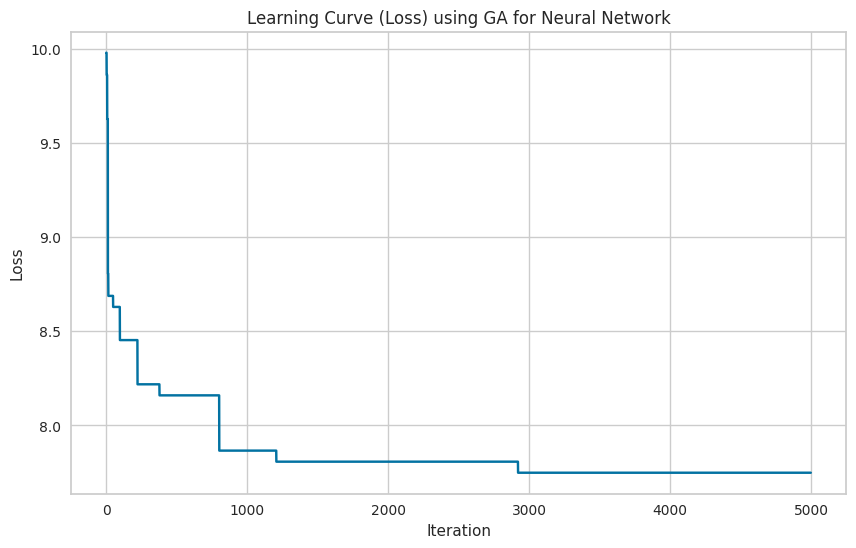

In [25]:
nn_model = mlrose.NeuralNetwork(
    hidden_nodes=[50], 
    activation='relu', 
    algorithm='genetic_alg', 
    max_iters=5000, 
    bias=True, 
    is_classifier=True, 
    learning_rate=0.02, 
    early_stopping=False, 
    clip_max=1e+10, 
    max_attempts=100, 
    random_state=42, 
    curve=True,
    mutation_prob=0.2,
    pop_size=100
)

# Fit the neural network
nn_model.fit(X_train, y_train)

fitness_curve = nn_model.fitness_curve

# Transform fitness to loss if necessary
# Assuming fitness is actually negative log loss, otherwise adjust as needed
loss_curve = -fitness_curve

# Plotting the loss curve
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(nn_model.fitness_curve)), nn_model.fitness_curve[:,0])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Learning Curve (Loss) using GA for Neural Network")
plt.grid(visible=True)
plt.legend(frameon=False)
plt.savefig('LossCurveforNN_GAFinal', dpi=300)
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

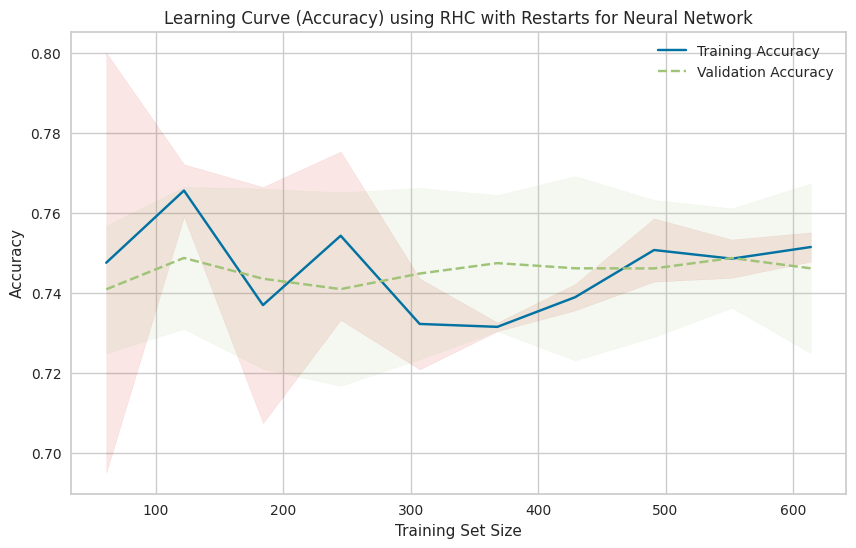

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

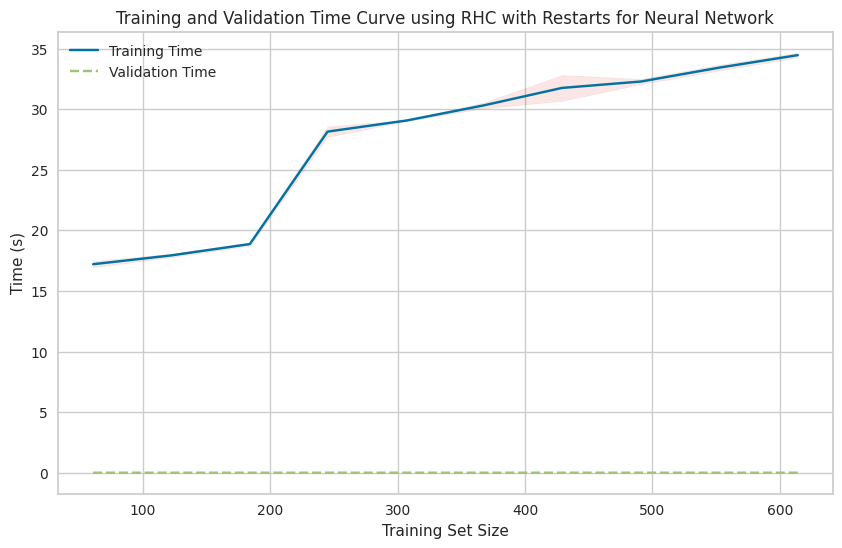

In [41]:
X_train, X_test, y_train, y_test = train_test_split(cX, cY, test_size=0.2, random_state=42)

# Define a function to create the neural network model
# Define a function to create the neural network model
def create_nn_model():
    return mlrose.NeuralNetwork(
        hidden_nodes=[50], 
        activation='relu', 
        algorithm='random_hill_climb', 
        max_iters=1000, 
        bias=True, 
        is_classifier=True, 
        learning_rate=0.02, 
        early_stopping=True, 
        clip_max=1e+10, 
        max_attempts=100, 
        random_state=42, 
        curve=True,
        restarts=10
    )

# Create a pipeline with standard scaler and the neural network model
pipeline = make_pipeline(StandardScaler(), create_nn_model())

# Use learning_curve to get the training and validation scores and times
train_sizes, train_scores, validation_scores, fit_times, score_times = learning_curve(
    estimator=pipeline,
    X=cX,
    y=cY,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    return_times=True,
    random_state=42
)

# Calculate the mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Calculate the mean and standard deviation for fit times
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

# Calculate the mean and standard deviation for score times
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

# Plotting the accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, validation_mean, label='Validation Accuracy', linestyle='--')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, alpha=0.1, color="g")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Accuracy) using RHC with Restarts for Neural Network")
plt.grid(True)
plt.legend(frameon=False)
plt.savefig('AccuracyCurveforNN_RHC_Restarts_with_Validation', dpi=300)
plt.show()

# Plotting the clock time curves for fitting and scoring in one plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, fit_times_mean, label='Training Time')
plt.fill_between(train_sizes, fit_times_mean - fit_times_std, fit_times_mean + fit_times_std, alpha=0.1, color="r")
plt.plot(train_sizes, score_times_mean, label='Validation Time', linestyle='--')
plt.fill_between(train_sizes, score_times_mean - score_times_std, score_times_mean + score_times_std, alpha=0.1, color="g")
plt.xlabel("Training Set Size")
plt.ylabel("Time (s)")
plt.title("Training and Validation Time Curve using RHC with Restarts for Neural Network")
plt.grid(True)
plt.legend(frameon=False)
plt.savefig('TimeCurveforNN_RHC_Restarts', dpi=300)
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

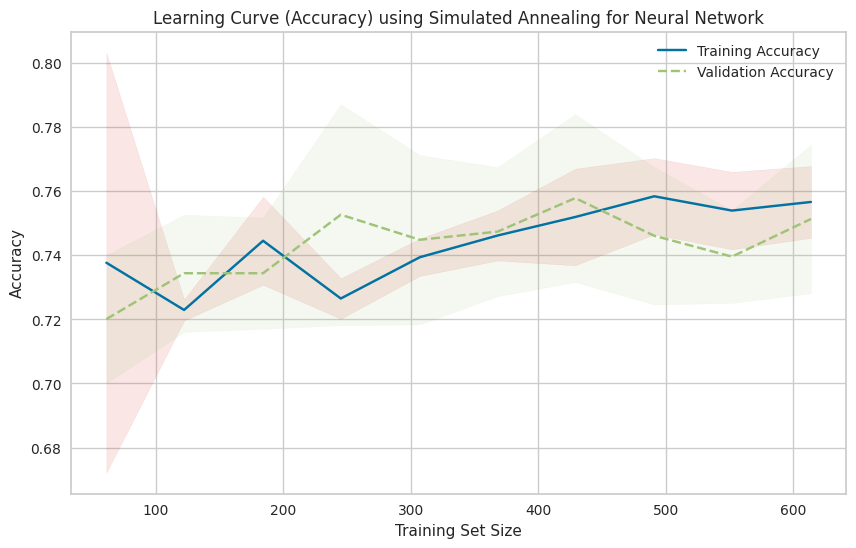

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

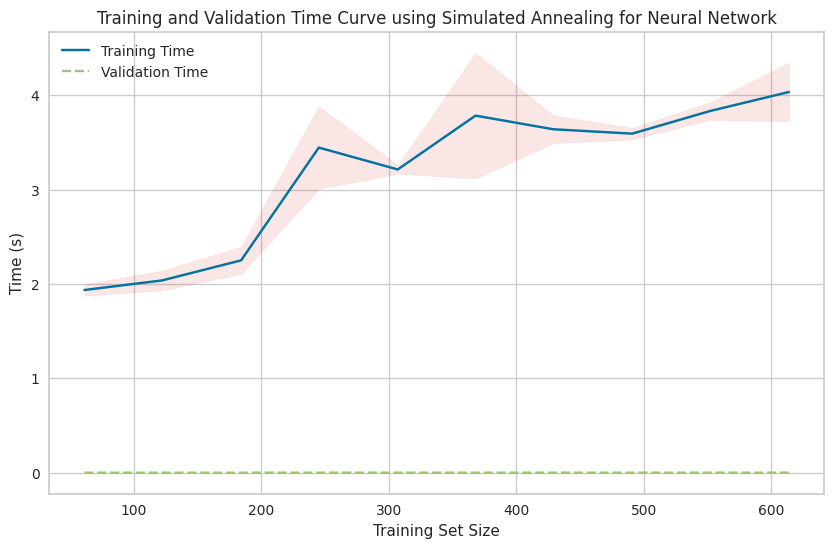

In [42]:
X_train, X_test, y_train, y_test = train_test_split(cX, cY, test_size=0.2, random_state=42)

# Define a function to create the neural network model
def create_nn_model():
    schedule = mlrose.GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001)
    return mlrose.NeuralNetwork(
        hidden_nodes=[50], 
        activation='relu', 
        algorithm='simulated_annealing', 
        max_iters=1000, 
        bias=True, 
        is_classifier=True, 
        learning_rate=0.1, 
        early_stopping=True, 
        clip_max=1e+10, 
        max_attempts=100, 
        random_state=42, 
        curve=True,
        schedule=schedule
    )

# Create a pipeline with standard scaler and the neural network model
pipeline = make_pipeline(StandardScaler(), create_nn_model())

# Use learning_curve to get the training and validation scores and times
train_sizes, train_scores, validation_scores, fit_times, score_times = learning_curve(
    estimator=pipeline,
    X=cX,
    y=cY,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    return_times=True,
    random_state=42
)

# Calculate the mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Calculate the mean and standard deviation for fit times
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

# Calculate the mean and standard deviation for score times
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

# Plotting the accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, validation_mean, label='Validation Accuracy', linestyle='--')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, alpha=0.1, color="g")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Accuracy) using Simulated Annealing for Neural Network")
plt.grid(True)
plt.legend(frameon=False)
plt.savefig('AccuracyCurveforNN_SA_with_Validation', dpi=300)
plt.show()

# Plotting the clock time curves for fitting and scoring in one plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, fit_times_mean, label='Training Time')
plt.fill_between(train_sizes, fit_times_mean - fit_times_std, fit_times_mean + fit_times_std, alpha=0.1, color="r")
plt.plot(train_sizes, score_times_mean, label='Validation Time', linestyle='--')
plt.fill_between(train_sizes, score_times_mean - score_times_std, score_times_mean + score_times_std, alpha=0.1, color="g")
plt.xlabel("Training Set Size")
plt.ylabel("Time (s)")
plt.title("Training and Validation Time Curve using Simulated Annealing for Neural Network")
plt.grid(True)
plt.legend(frameon=False)
plt.savefig('TimeCurveforNN_SA', dpi=300)
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

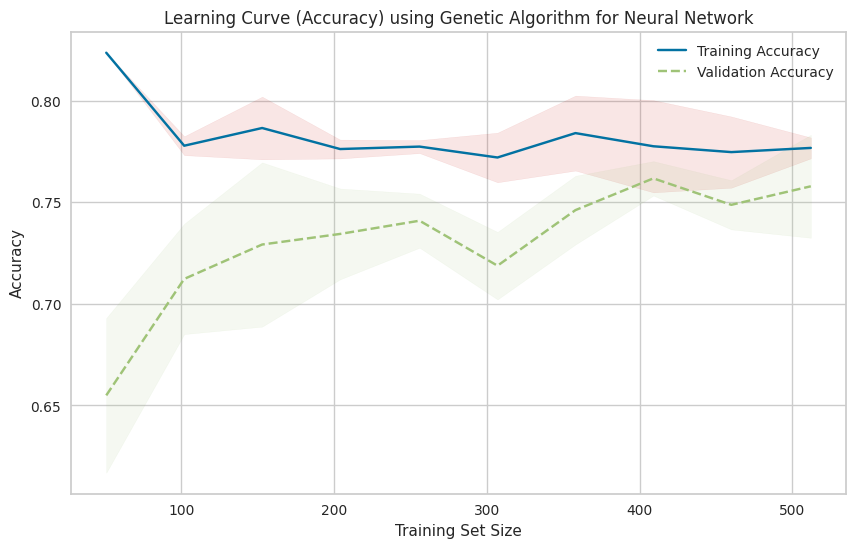

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

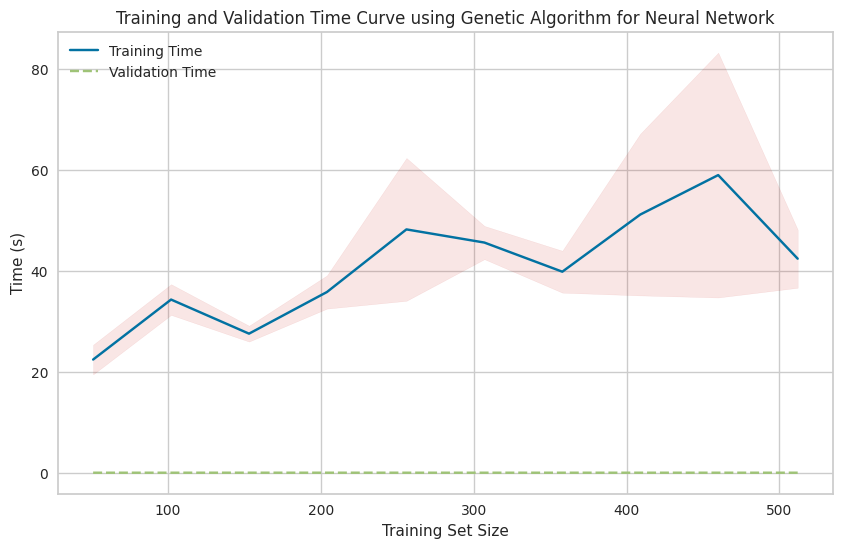

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(cX, cY, test_size=0.2, random_state=42)

# Define a function to create the neural network model using Genetic Algorithm
def create_nn_model():
    return mlrose.NeuralNetwork(
        hidden_nodes=[50], 
        activation='relu', 
        algorithm='genetic_alg', 
        max_iters=1000, 
        bias=True, 
        is_classifier=True, 
        learning_rate=0.02, 
        early_stopping=True, 
        clip_max=1e+10, 
        max_attempts=100, 
        random_state=42, 
        curve=True,
        mutation_prob=0.2,
        pop_size=100
    )

# Create a pipeline with standard scaler and the neural network model
pipeline = make_pipeline(StandardScaler(), create_nn_model())

# Use learning_curve to get the training and validation scores and times
train_sizes, train_scores, validation_scores, fit_times, score_times = learning_curve(
    estimator=pipeline,
    X=cX,
    y=cY,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3,
    scoring='accuracy',
    return_times=True,
    random_state=42
)

# Calculate the mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Calculate the mean and standard deviation for fit times
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

# Calculate the mean and standard deviation for score times
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

# Plotting the accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, validation_mean, label='Validation Accuracy', linestyle='--')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, alpha=0.1, color="g")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Accuracy) using Genetic Algorithm for Neural Network")
plt.grid(True)
plt.legend(frameon=False)
plt.savefig('AccuracyCurveforNN_GA_with_Validation', dpi=300)
plt.show()

# Plotting the clock time curves for fitting and scoring in one plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, fit_times_mean, label='Training Time')
plt.fill_between(train_sizes, fit_times_mean - fit_times_std, fit_times_mean + fit_times_std, alpha=0.1, color="r")
plt.plot(train_sizes, score_times_mean, label='Validation Time', linestyle='--')
plt.fill_between(train_sizes, score_times_mean - score_times_std, score_times_mean + score_times_std, alpha=0.1, color="g")
plt.xlabel("Training Set Size")
plt.ylabel("Time (s)")
plt.title("Training and Validation Time Curve using Genetic Algorithm for Neural Network")
plt.grid(True)
plt.legend(frameon=False)
plt.savefig('TimeCurveforNN_GA', dpi=300)
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

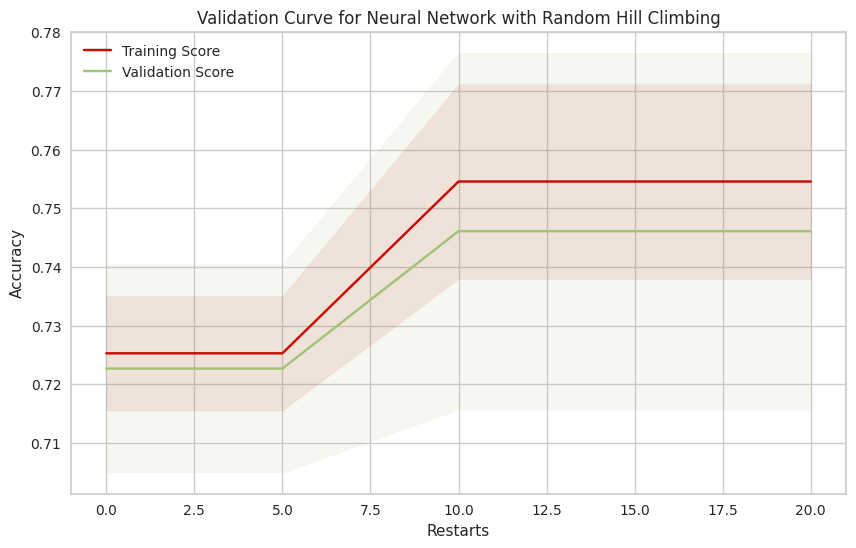

In [7]:
def create_nn_model(restarts):
    return mlrose.NeuralNetwork(
        hidden_nodes=[50], 
        activation='relu', 
        algorithm='random_hill_climb', 
        max_iters=1000, 
        bias=True, 
        is_classifier=True, 
        learning_rate=0.02, 
        early_stopping=True, 
        clip_max=1e+10, 
        max_attempts=100, 
        random_state=42, 
        curve=True,
        restarts=restarts
    )

# Create a pipeline with standard scaler and the neural network model
def create_pipeline(restarts):
    return make_pipeline(StandardScaler(), create_nn_model(restarts))

# Define the range of the hyperparameter 'restarts'
param_range = [0, 5, 10, 15, 20]

# Use validation_curve to get training and validation scores
train_scores, validation_scores = validation_curve(
    estimator=create_pipeline(0),
    X=cX,
    y=cY,
    param_name='neuralnetwork__restarts',
    param_range=param_range,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Calculate the mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plotting the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label='Training Score', color='r')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.plot(param_range, validation_mean, label='Validation Score', color='g')
plt.fill_between(param_range, validation_mean - validation_std, validation_mean + validation_std, alpha=0.1, color='g')
plt.xlabel('Restarts')
plt.ylabel('Accuracy')
plt.title('Validation Curve for Neural Network with Random Hill Climbing')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('ValidationCurveforNN_RHC_Restarts', dpi=300)
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

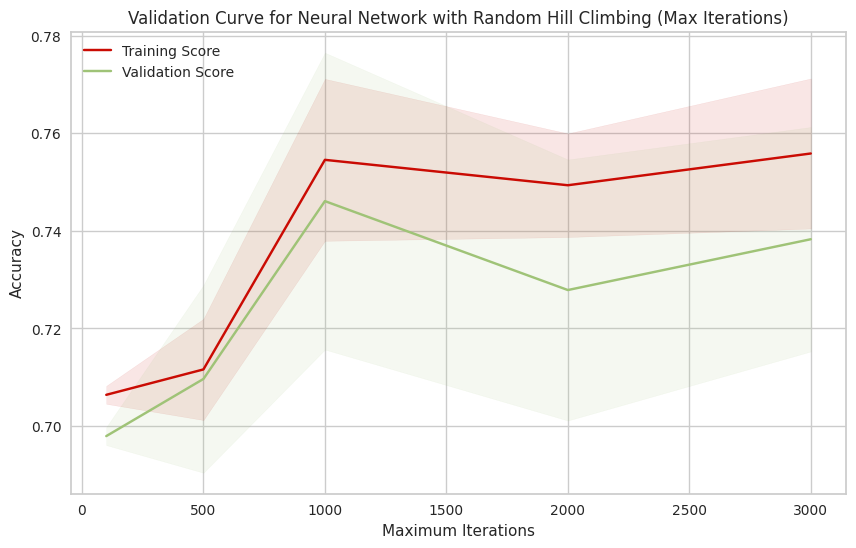

In [8]:
def create_nn_model(max_iters):
    return mlrose.NeuralNetwork(
        hidden_nodes=[50], 
        activation='relu', 
        algorithm='random_hill_climb', 
        max_iters=max_iters, 
        bias=True, 
        is_classifier=True, 
        learning_rate=0.02, 
        early_stopping=True, 
        clip_max=1e+10, 
        max_attempts=100, 
        random_state=42, 
        curve=True,
        restarts=10
    )

# Create a pipeline with standard scaler and the neural network model
def create_pipeline(max_iters):
    return make_pipeline(StandardScaler(), create_nn_model(max_iters))

# Define the range of the hyperparameter 'max_iters'
param_range = [100, 500, 1000, 2000, 3000]

# Use validation_curve to get training and validation scores for 'max_iters'
train_scores, validation_scores = validation_curve(
    estimator=create_pipeline(100),
    X=cX,
    y=cY,
    param_name='neuralnetwork__max_iters',
    param_range=param_range,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Calculate the mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plotting the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label='Training Score', color='r')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.plot(param_range, validation_mean, label='Validation Score', color='g')
plt.fill_between(param_range, validation_mean - validation_std, validation_mean + validation_std, alpha=0.1, color='g')
plt.xlabel('Maximum Iterations')
plt.ylabel('Accuracy')
plt.title('Validation Curve for Neural Network with Random Hill Climbing (Max Iterations)')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('ValidationCurveforNN_RHC_MaxIters', dpi=300)
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

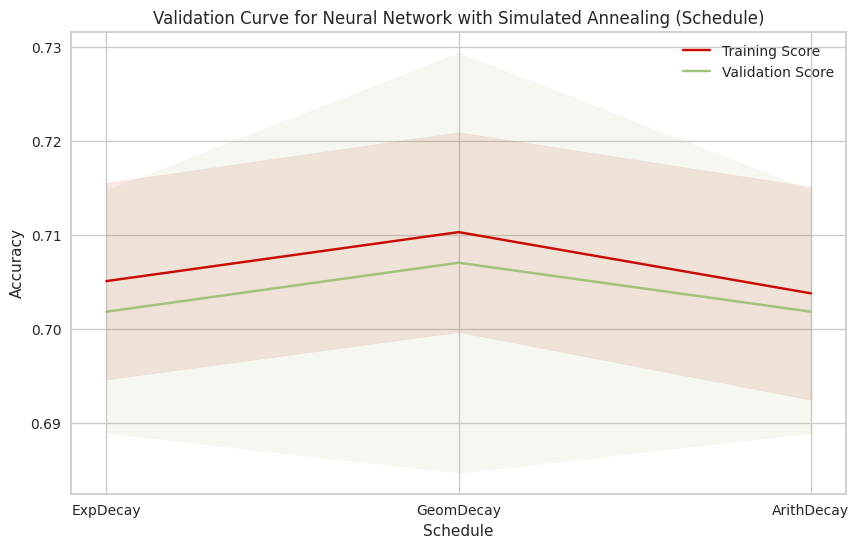

In [9]:
def create_nn_model(schedule):
    return mlrose.NeuralNetwork(
        hidden_nodes=[50], 
        activation='relu', 
        algorithm='simulated_annealing', 
        max_iters=1000, 
        bias=True, 
        is_classifier=True, 
        learning_rate=0.02, 
        early_stopping=True, 
        clip_max=1e+10, 
        max_attempts=100, 
        random_state=42, 
        curve=True,
        schedule=schedule
    )

# Create a pipeline with standard scaler and the neural network model
def create_pipeline(schedule):
    return make_pipeline(StandardScaler(), create_nn_model(schedule))

# Define the range of the hyperparameter 'schedule'
param_range = [mlrose.ExpDecay(), mlrose.GeomDecay(), mlrose.ArithDecay()]
param_names = ['ExpDecay', 'GeomDecay', 'ArithDecay']

# Use validation_curve to get training and validation scores for 'schedule'
train_scores, validation_scores = validation_curve(
    estimator=create_pipeline(mlrose.ExpDecay()),
    X=cX,
    y=cY,
    param_name='neuralnetwork__schedule',
    param_range=param_range,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Calculate the mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plotting the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_names, train_mean, label='Training Score', color='r')
plt.fill_between(param_names, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.plot(param_names, validation_mean, label='Validation Score', color='g')
plt.fill_between(param_names, validation_mean - validation_std, validation_mean + validation_std, alpha=0.1, color='g')
plt.xlabel('Schedule')
plt.ylabel('Accuracy')
plt.title('Validation Curve for Neural Network with Simulated Annealing (Schedule)')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('ValidationCurveforNN_SA_Schedule', dpi=300)
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

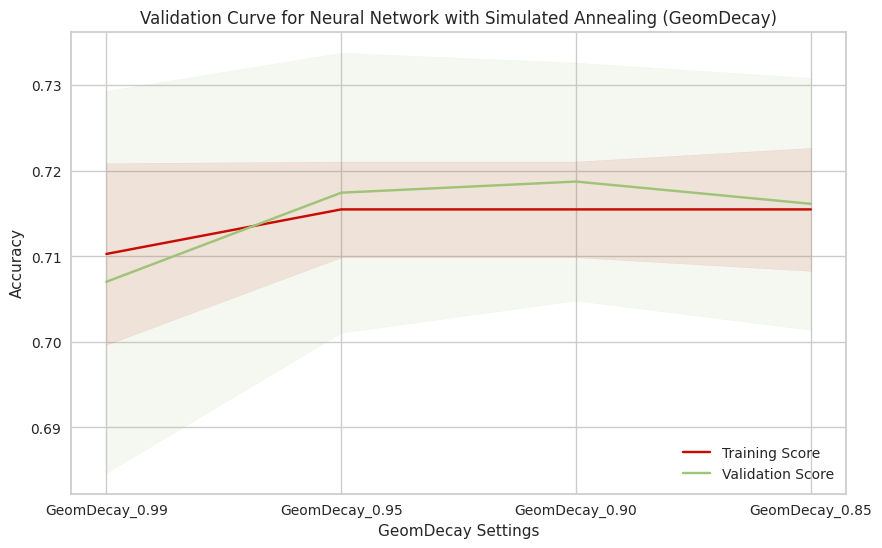

In [10]:
def create_nn_model(schedule):
    return mlrose.NeuralNetwork(
        hidden_nodes=[50], 
        activation='relu', 
        algorithm='simulated_annealing', 
        max_iters=1000, 
        bias=True, 
        is_classifier=True, 
        learning_rate=0.02, 
        early_stopping=True, 
        clip_max=1e+10, 
        max_attempts=100, 
        random_state=42, 
        curve=True,
        schedule=schedule
    )

# Create a pipeline with standard scaler and the neural network model
def create_pipeline(schedule):
    return make_pipeline(StandardScaler(), create_nn_model(schedule))

# Define the range of the hyperparameter 'schedule' with different decay rates for GeomDecay
param_range = [
    mlrose.GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001),
    mlrose.GeomDecay(init_temp=1.0, decay=0.95, min_temp=0.001),
    mlrose.GeomDecay(init_temp=1.0, decay=0.90, min_temp=0.001),
    mlrose.GeomDecay(init_temp=1.0, decay=0.85, min_temp=0.001)
]
param_names = ['GeomDecay_0.99', 'GeomDecay_0.95', 'GeomDecay_0.90', 'GeomDecay_0.85']

# Use validation_curve to get training and validation scores for 'schedule'
train_scores, validation_scores = validation_curve(
    estimator=create_pipeline(mlrose.GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001)),
    X=cX,
    y=cY,
    param_name='neuralnetwork__schedule',
    param_range=param_range,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Calculate the mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plotting the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_names, train_mean, label='Training Score', color='r')
plt.fill_between(param_names, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.plot(param_names, validation_mean, label='Validation Score', color='g')
plt.fill_between(param_names, validation_mean - validation_std, validation_mean + validation_std, alpha=0.1, color='g')
plt.xlabel('GeomDecay Settings')
plt.ylabel('Accuracy')
plt.title('Validation Curve for Neural Network with Simulated Annealing (GeomDecay)')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('ValidationCurveforNN_SA_GeomDecay', dpi=300)
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

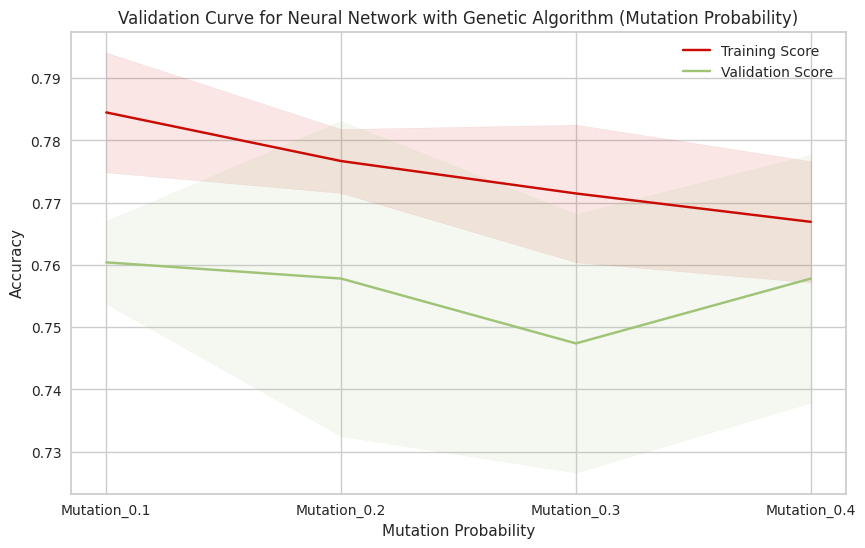

In [8]:
def create_nn_model(mutation_prob):
    return mlrose.NeuralNetwork(
        hidden_nodes=[50], 
        activation='relu', 
        algorithm='genetic_alg', 
        max_iters=1000, 
        bias=True, 
        is_classifier=True, 
        learning_rate=0.02, 
        early_stopping=True, 
        clip_max=1e+10, 
        max_attempts=100, 
        random_state=42, 
        curve=True,
        mutation_prob=mutation_prob,
        pop_size=100
    )

# Create a pipeline with standard scaler and the neural network model
def create_pipeline(mutation_prob):
    return make_pipeline(StandardScaler(), create_nn_model(mutation_prob))

# Define the range of the hyperparameter 'mutation_prob'
param_range = [0.01, 0.05, 0.1, 0.2]
param_names = ['Mutation_0.01', 'Mutation_0.05', 'Mutation_0.1', 'Mutation_0.2']

# Use validation_curve to get training and validation scores for 'mutation_prob'
train_scores, validation_scores = validation_curve(
    estimator=create_pipeline(0.1),
    X=cX,
    y=cY,
    param_name='neuralnetwork__mutation_prob',
    param_range=param_range,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Calculate the mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plotting the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_names, train_mean, label='Training Score', color='r')
plt.fill_between(param_names, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.plot(param_names, validation_mean, label='Validation Score', color='g')
plt.fill_between(param_names, validation_mean - validation_std, validation_mean + validation_std, alpha=0.1, color='g')
plt.xlabel('Mutation Probability')
plt.ylabel('Accuracy')
plt.title('Validation Curve for Neural Network with Genetic Algorithm (Mutation Probability)')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('ValidationCurveforNN_GA_MutationProb', dpi=300)
plt.show()

In [9]:
def create_nn_model(pop_size):
    return mlrose.NeuralNetwork(
        hidden_nodes=[50], 
        activation='relu', 
        algorithm='genetic_alg', 
        max_iters=1000, 
        bias=True, 
        is_classifier=True, 
        learning_rate=0.02, 
        early_stopping=True, 
        clip_max=1e+10, 
        max_attempts=100, 
        random_state=42, 
        curve=True,
        mutation_prob=0.2,
        pop_size=pop_size
    )

# Create a pipeline with standard scaler and the neural network model
def create_pipeline(pop_size):
    return make_pipeline(StandardScaler(), create_nn_model(pop_size))

# Define the range of the hyperparameter 'pop_size'
param_range = [50, 100, 200, 300]
param_names = ['PopSize_50', 'PopSize_100', 'PopSize_200', 'PopSize_300']

# Use validation_curve to get training and validation scores for 'pop_size'
train_scores, validation_scores = validation_curve(
    estimator=create_pipeline(50),
    X=cX,
    y=cY,
    param_name='neuralnetwork__pop_size',
    param_range=param_range,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Calculate the mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plotting the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_names, train_mean, label='Training Score', color='r')
plt.fill_between(param_names, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.plot(param_names, validation_mean, label='Validation Score', color='g')
plt.fill_between(param_names, validation_mean - validation_std, validation_mean + validation_std, alpha=0.1, color='g')
plt.xlabel('Population Size')
plt.ylabel('Accuracy')
plt.title('Validation Curve for Neural Network with Genetic Algorithm (Population Size)')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('ValidationCurveforNN_GA_PopSize', dpi=300)
plt.show()

In [61]:
HTML(cv_results_df[['mean_test_score', 'rank_test_score', 'mean_train_score', 'param_activation', 'param_hidden_layer_sizes', 'param_learning_rate',
                    'param_max_iters', 'param_restarts']].to_html())

,mean_test_score,rank_test_score,mean_train_score,param_activation,param_hidden_layer_sizes,param_learning_rate,param_max_iters,param_restarts
0,0.726050,2,0.728150,sigmoid,[50],0.02,500,1
1,0.726220,1,0.728295,sigmoid,[50],0.02,500,2
2,0.722117,3,0.720517,sigmoid,[50],0.02,500,5
3,0.709457,4,0.718697,sigmoid,[50],0.02,500,10


In [59]:
curves_df.columns

Index(['Iteration', 'Time', 'Fitness', 'FEvals', 'max_iters', 'learning_rate',
       'restarts', 'init_state', 'algorithm', 'activation', 'bias',
       'early_stopping', 'clip_max', 'hidden_layer_sizes',
       'learning_rate_init', 'max_attempts', 'current_restart'],
      dtype='object')

In [29]:
y_test_pred = grid_search_cv.predict(X_test)
y_test_accuracy = accuracy_score(y_test, y_test_pred)
print(y_test_accuracy)

0.6818181818181818


In [30]:
y_train_pred = grid_search_cv.predict(X_train)
y_train_accuracy = accuracy_score(y_train, y_train_pred)
print(y_train_accuracy)

0.762214983713355


In [31]:
HTML(run_stats_df[['current_restart', 'Iteration', 'Fitness', 'FEvals', 'Time', 'learning_rate']].to_html())

,current_restart,Iteration,Fitness,FEvals,Time,learning_rate
0,0,0,0.923225,1,0.005775,0.02
1,0,50,0.834336,78,0.166974,0.02
2,0,100,0.783948,151,0.329139,0.02
3,0,250,0.651581,369,0.813595,0.02
4,0,500,0.552805,736,1.643159,0.02
5,0,1000,0.552805,736,1.643159,0.02
6,1,0,0.923225,736,1.658282,0.02
7,1,50,0.835829,813,1.828328,0.02
8,1,100,0.802802,885,2.087820,0.02
9,1,250,0.695362,1106,2.584250,0.02


,mean_test_score,rank_test_score,mean_train_score,param_activation,param_hidden_layer_sizes,param_learning_rate,param_max_iters,param_restarts
0,0.697141,5,0.713737,sigmoid,[50],0.02,500,1
1,0.696886,6,0.709875,sigmoid,[50],0.02,500,2
2,0.688966,9,0.700601,sigmoid,[50],0.02,500,5
3,0.695239,8,0.711023,sigmoid,[50],0.02,500,10
4,0.718547,2,0.728455,relu,[50],0.02,500,1
5,0.710233,4,0.733286,relu,[50],0.02,500,2
6,0.711094,3,0.722318,relu,[50],0.02,500,5
7,0.726258,1,0.737405,relu,[50],0.02,500,10
8,0.686676,11,0.706698,tanh,[50],0.02,500,1
9,0.686975,10,0.707068,tanh,[50],0.02,500,2


In [ ]:
# Add a column for testing accuracy in the curves_df
def compute_test_accuracy(row):
    model = mlrose.NeuralNetwork(hidden_nodes=[50],
                                 activation='relu',
                                 algorithm='random_hill_climb',
                                 learning_rate=row['param_learning_rate'],
                                 restarts=row['param_restarts'],
                                 clip_max=row['param_clip_max'],
                                 max_iters=row['Iteration'],
                                 bias=True,
                                 early_stopping=True,
                                 max_attempts=500,
                                 random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

curves_df['Test_Accuracy'] = curves_df.apply(compute_test_accuracy, axis=1)

# Group by iteration and calculate mean and standard deviation for test accuracy
mean_accuracy = curves_df.groupby('Iteration')['Test_Accuracy'].mean()
std_accuracy = curves_df.groupby('Iteration')['Test_Accuracy'].std()

# Plot the accuracy curve with mean and standard deviation
plt.figure(figsize=(10, 6))
plt.plot(mean_accuracy.index, mean_accuracy, label='Mean Test Accuracy', color='b')
plt.fill_between(mean_accuracy.index, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, color='b', alpha=0.2, label='Standard Deviation')
plt.title('Test Accuracy Curve with Mean and Standard Deviation for Random Hill Climb')
plt.xlabel('Iterations')
plt.ylabel('Test Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
sorted_rhc_run_curves = best_rhc_fitness_curves.sort_values(by=['Fitness', 'Time', 'FEvals', 'max_iters'], 
                                                   ascending=[False, True, True, True])

# Display the sorted DataFrame
#top_5_rhc_run_curves = sorted_rhc_run_curves.head(5)
#print(top_5_rhc_run_curves)

# Extract the best parameters from the sorted DataFrame
best_rhc_stats = sorted_rhc_run_curves.iloc[0]
best_fitness = best_rhc_stats['Fitness']
best_time = best_rhc_stats['Time']
best_fevals = best_rhc_stats['FEvals']
best_max_iters = best_rhc_stats['max_iters']
best_restarts = best_rhc_stats['Restarts']